 **1.  Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
#from collections import Counter
import cv2, os
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from keras.optimizers import Adam
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**2. Load The Dataset and Data visualization**

In [2]:
train_dir = '/kaggle/input/sign-language-recognition-dataset/dataset/train'
test_dir = '/kaggle/input/sign-language-recognition-dataset/dataset/test'

In [3]:
classes = 29
img_size = (227, 227)

unique_labels =  ['N', 'R', 'space', 'B', 'I', 'del', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', 'C', 'P', 'L', 'W', 'D', 'nothing', 'J']


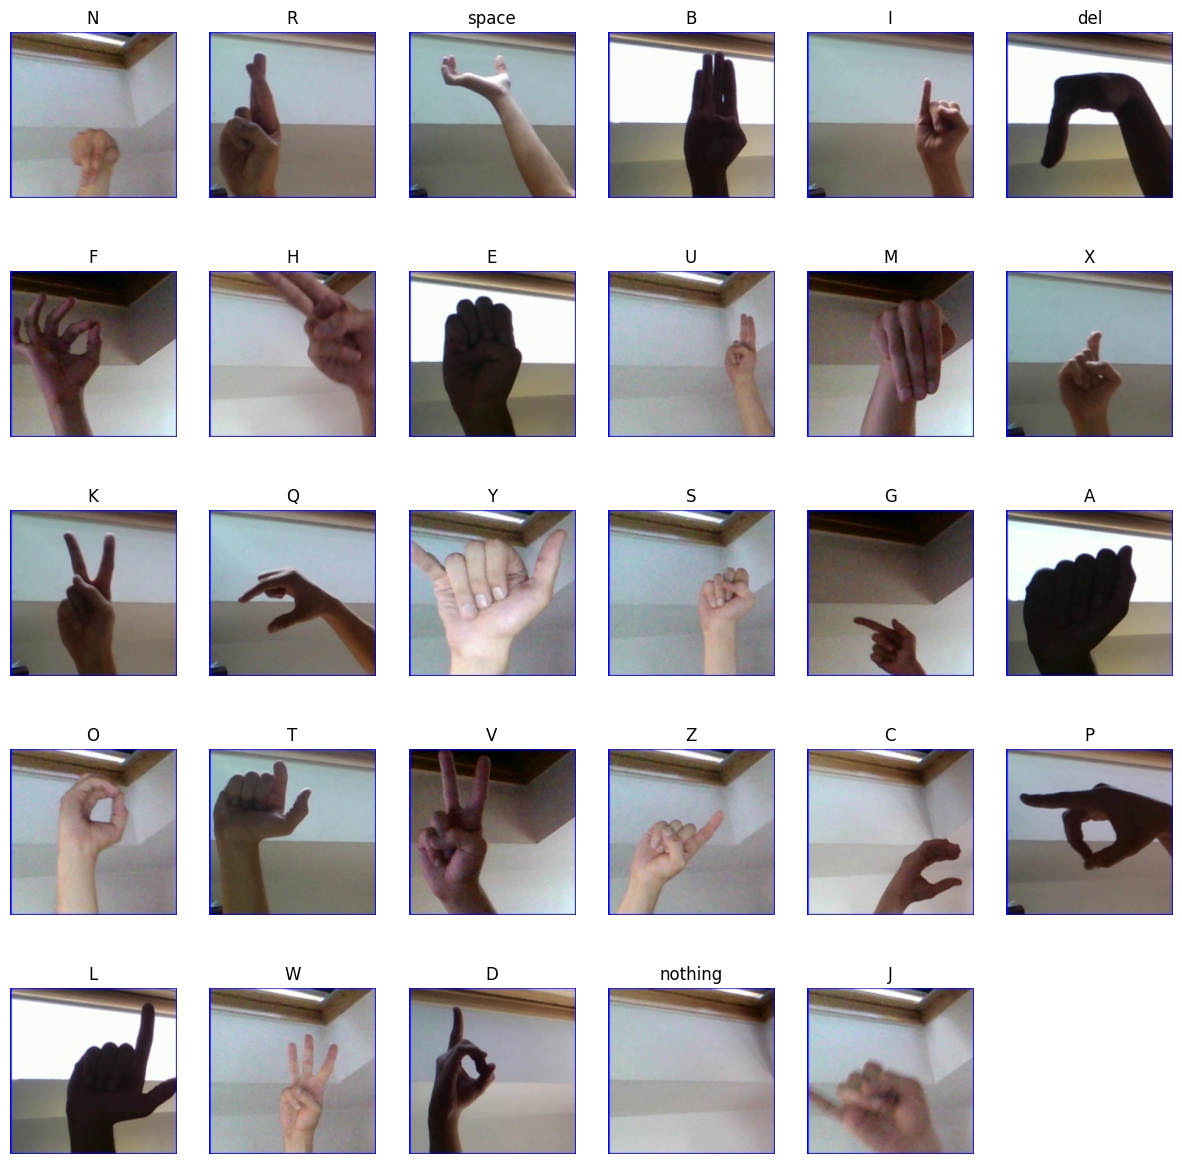

In [4]:
def load_unique():
    size_img = img_size
    images_for_plot = []
    labels_for_plot = []
    for folder in os.listdir(train_dir):
        for file in os.listdir(train_dir + '/' + folder):
            filepath = train_dir + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, size_img)
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

fig = plt.figure(figsize = (15,15))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
def Load_image_data(data_dir, img_size, num_classes):
    # Load the image data
    X = []
    y = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=img_size, grayscale=True)
            img = img_to_array(img)
            X.append(img)
            y.append(class_name)
    X = np.array(X)
    y = np.array(y)
    return X, y
        
X, y = Load_image_data(train_dir, img_size, classes)

/opt/conda/lib/python3.10/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [6]:
print(len(X), len(y))

23347 23347


**4. Data preprocessing**

In [7]:
from sklearn.preprocessing import LabelEncoder
def preprocess_image_data(X, y):

    # Encode the labels
    num_classes = 29
    le = LabelEncoder()
    y = le.fit_transform(y)
    y = np_utils.to_categorical(y, num_classes)

    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    # Reshape the input data
    x_train = x_train.reshape(x_train.shape[0], img_size[0], img_size[1], 1)
    x_test = x_test.reshape(x_test.shape[0], img_size[0], img_size[1], 1)

    # Normalize the pixel values
    x_train = x_train.astype('float16') / 255
    x_test = x_test.astype('float16') / 255

    return x_train, x_test, y_train, y_test

In [8]:
x_train, x_test, y_train, y_test = preprocess_image_data(X,y)


In [9]:
# Check the shapes of the data
print('Training data X:', x_train.shape)
print('Test data X:', x_test.shape)
print('Training data y:', y_train.shape)
print('Test data y:', y_test.shape)

Training data X: (19844, 227, 227, 1)
Test data X: (3503, 227, 227, 1)
Training data y: (19844, 29)
Test data y: (3503, 29)


**5. Define The CNN models**

In [10]:
classes = 29
epochs = 10
batch = 128

* 5.1 LeNet

In [11]:
# Define the input shape
input_shape = (227, 227, 1)

# Define the LeNet model
modelLeNet = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1280, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=classes, activation='softmax')
])

# Compile the model
modelLeNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
modelLeNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 128)     3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       819456    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 43264)             0         
                                                                 
 dense (Dense)               (None, 1280)              5

* 5.2 AlexNet

In [12]:
# Define the input shape
input_shape = (227, 227, 1)

# Define the AlexNet model
modelAlex = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=128, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4096, activation='relu'),
    tf.keras.layers.Dense(units=4096, activation='relu'),
    tf.keras.layers.Dense(units=classes, activation='softmax')
])

# Compile the model
modelAlex.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
modelAlex.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 55, 55, 128)       15616     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 23, 256)       819456    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 384)         885120    
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 384)        

**6. Function Evaluate Model**

In [15]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Evaluate the model on the training data
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
    train_acc_default = train_acc
    print('\nTrain accuracy:', round(train_acc*100, 2), "%")

    # Evaluate the model on the testing data
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Testing Loss: {:.4f}, Testing Accuracy: {:.4f}".format(loss, accuracy))

    # Make predictions using the model
    y_pred = model.predict(X_test)

    # Convert one-hot encoded vectors back to labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

    # Print the precision, recall, and F1 score
    print("Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(precision, recall, f1))

In [16]:
def plot_results(model):
  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()


**7. Train Model**

* 7.1 LeNet

In [17]:
history = modelLeNet.fit(x_train, y_train, batch_size=batch, epochs=epochs, validation_split=0.2, shuffle=True, verbose=1)


Epoch 1/10
125/125 [==============================] - 957s 8s/step - loss: 2.7522 - accuracy: 0.2131 - val_loss: 1.7492 - val_accuracy: 0.4465
Epoch 2/10
125/125 [==============================] - 958s 8s/step - loss: 1.0891 - accuracy: 0.6527 - val_loss: 0.9143 - val_accuracy: 0.6893
Epoch 3/10
125/125 [==============================] - 957s 8s/step - loss: 0.5038 - accuracy: 0.8310 - val_loss: 0.4827 - val_accuracy: 0.8408
Epoch 4/10
125/125 [==============================] - 955s 8s/step - loss: 0.2641 - accuracy: 0.9092 - val_loss: 0.5177 - val_accuracy: 0.8335
Epoch 5/10
125/125 [==============================] - 954s 8s/step - loss: 0.2112 - accuracy: 0.9294 - val_loss: 0.4534 - val_accuracy: 0.8546
Epoch 6/10
125/125 [==============================] - 955s 8s/step - loss: 0.1289 - accuracy: 0.9591 - val_loss: 0.3985 - val_accuracy: 0.8806
Epoch 7/10
125/125 [==============================] - 955s 8s/step - loss: 0.1650 - accuracy: 0.9511 - val_loss: 1.8066 - val_accuracy: 0.6934

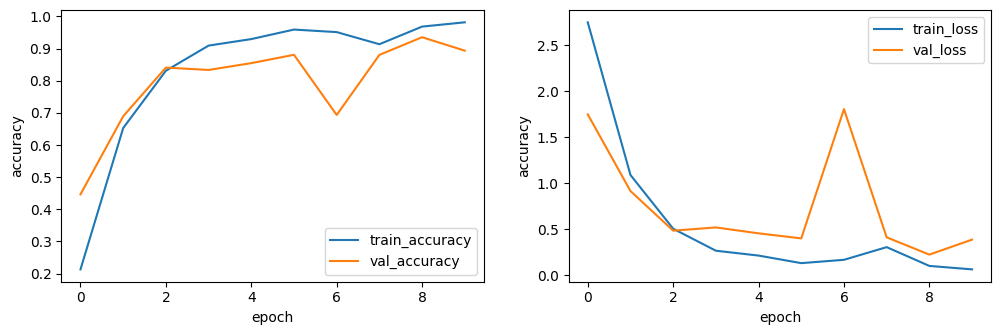

In [20]:
plot_results(modelLeNet)

In [ ]:
# Evaluate the LeNet model on the testing data
evaluate_model(modelLeNet, x_train, y_train, x_test, y_test)

* 7.2 AlexNet

In [ ]:
history = modelAlex.fit(x_train, y_train, batch_size=batch, epochs = 10, validation_split=0.2, shuffle=True, verbose=1)

In [ ]:
evaluate_model(modelAlex, X_train, y_train, X_test, y_test)

In [ ]:
plot_results(modelAlex)